In [1]:
%load_ext autoreload
%autoreload 2 

In [10]:
import h5py
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import G2Net2022Dataset
from tqdm.notebook import tqdm

from transforms import *
import albumentations as A

In [3]:
df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
df = df.loc[df['target'] != -1]

In [4]:
v1_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v1.csv')
v8_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v8.csv')
v9_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v9.csv')
v10_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v10.csv')

In [7]:
# sns.distplot(v1_df['H1_F1'])
# sns.distplot(v10_df['H1_F1'])

torch.Size([3, 360, 512])


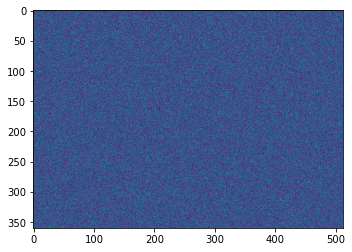

In [13]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from transforms import *

ds = G2Net2022Dataset(
    test, 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'), 
    # match_time=True,
    spec_diff=True,
    resize_factor=8, 
    transforms=A.Compose([
        # A.Resize(360, 1024), 
        ShiftImage(x_max=100, y_max=100, p=1.0),
        RandomCrop(512),
        ToTensorV2(), 
        # FrequencyMaskingTensor(p=1.0), 
        # TimeMaskingTensor(128, p=1.0),
        # FrequencyMaskingTensor(p=1.0),
        ]),
    normalize='laeyoung')
for i in range(20):
    data = ds[i][0]
    print(data.shape)
    # plt.imshow(data.permute(1,2,0)[:, :1000])
    plt.imshow(ds[i][0][0, :, :1000])
    plt.show()
    break

# Get metadata

In [5]:
# signal_summary = []
# ds = G2Net2022Dataset(df, resize_factor=4, )
# for idx in tqdm(range(len(df))):
#     try:
#         spec_h1, spec_l1 = ds[idx][0]
#     except:
#         print(f'ERROR: {idx}')
#         continue
#     signal_summary.append({
#         'idx': idx,
#         'h1_mean': spec_h1.mean().item(),
#         'h1_max': spec_h1.max().item(),
#         'h1_min': spec_h1.min().item(),
#         'l1_mean': spec_l1.mean().item(),
#         'l1_max': spec_l1.max().item(),
#         'l1_min': spec_l1.min().item()
#     })
# signal_summary = pd.DataFrame(signal_summary)


In [6]:
# signal_summary.describe()

In [15]:
def count_gaps(timestamps, Tsft=1800):
    gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)
    return (gap_length > 0).sum()

In [11]:
signal_summary = []
for gid in tqdm(df['id'].values[:100]):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/train/{gid}.pickle')
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

  0%|          | 0/100 [00:00<?, ?it/s]

,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
count,1.000000e+02,1.000000e+02,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.238172e+09,1.248557e+09,309.560000,4577.94000,33.597973,5.182819,0.647466,0.237088,1.238173e+09,1.248557e+09,306.400000,4588.380000,33.981945,5.183719,0.647401,0.237118
std,6.587994e+03,2.604688e+04,16.259462,75.71195,3.095104,0.006659,0.000985,0.000506,7.467070e+03,2.533038e+04,13.842549,80.843505,2.930361,0.006228,0.001086,0.000588
min,1.238166e+09,1.248513e+09,274.000000,4355.00000,28.056784,5.165467,0.645548,0.235584,1.238166e+09,1.248500e+09,268.000000,4340.000000,28.501242,5.172005,0.643672,0.235670
25%,1.238168e+09,1.248538e+09,299.750000,4520.75000,31.213326,5.178497,0.646719,0.236747,1.238168e+09,1.248539e+09,296.000000,4543.000000,31.940144,5.179838,0.646843,0.236708
50%,1.238170e+09,1.248555e+09,309.000000,4572.00000,32.695435,5.182665,0.647424,0.237113,1.238171e+09,1.248551e+09,307.000000,4601.500000,33.847111,5.183455,0.647288,0.237170
75%,1.238174e+09,1.248566e+09,320.250000,4635.50000,35.595478,5.186205,0.648134,0.237369,1.238176e+09,1.248570e+09,316.000000,4632.500000,35.513337,5.186945,0.647953,0.237517
max,1.238204e+09,1.248672e+09,352.000000,4798.00000,41.512852,5.198843,0.650289,0.238465,1.238197e+09,1.248651e+09,341.000000,4754.000000,45.811039,5.207669,0.649827,0.238426


In [17]:
signal_summary = []
data_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v9.csv').sample(200)
for gid in tqdm(data_df['id'].values):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/v9/{gid}.pickle')
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

  0%|          | 0/200 [00:00<?, ?it/s]

,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
count,2.000000e+02,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.238172e+09,1.248554e+09,307.135000,4585.820000,34.345959,5.185409,0.647685,0.237246,1.238173e+09,1.248555e+09,308.730000,4577.095000,34.214527,5.184874,0.647732,0.237282
std,6.540451e+03,2.289734e+04,15.031517,81.343478,4.870415,0.010730,0.001080,0.000631,7.464319e+03,2.287507e+04,14.874588,76.768895,5.917054,0.009487,0.001182,0.000638
min,1.238166e+09,1.248512e+09,272.000000,4382.000000,28.431526,5.161019,0.645012,0.235253,1.238166e+09,1.248502e+09,265.000000,4383.000000,28.003899,5.165280,0.644853,0.235551
25%,1.238168e+09,1.248539e+09,297.000000,4536.000000,31.557202,5.179626,0.647013,0.236830,1.238168e+09,1.248538e+09,299.000000,4524.750000,31.435245,5.179456,0.646960,0.236883
50%,1.238170e+09,1.248549e+09,306.000000,4584.500000,33.512100,5.183370,0.647723,0.237268,1.238171e+09,1.248549e+09,309.500000,4574.500000,32.990204,5.183290,0.647742,0.237332
75%,1.238174e+09,1.248565e+09,317.000000,4636.000000,35.670977,5.188011,0.648391,0.237628,1.238176e+09,1.248566e+09,319.000000,4630.000000,35.059322,5.187784,0.648361,0.237736
max,1.238202e+09,1.248649e+09,345.000000,4802.000000,72.962090,5.249333,0.651245,0.239736,1.238217e+09,1.248641e+09,346.000000,4852.000000,86.596695,5.239271,0.652471,0.239394


In [6]:
signal_summary = []
for gid in tqdm(test['id']):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle'
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

  0%|          | 0/7975 [00:00<?, ?it/s]

,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
count,7.975000e+03,7.975000e+03,7975.000000,7975.000000,7975.000000,7975.000000,7975.000000,7975.000000,7.975000e+03,7.975000e+03,7975.000000,7975.000000,7975.000000,7975.000000,7975.000000,7975.000000
mean,1.238173e+09,1.248555e+09,307.224953,4586.144828,72.578423,5.490926,0.681834,0.249631,1.238173e+09,1.248554e+09,307.471223,4584.289655,79.318947,5.292903,0.649997,0.237981
std,7.032005e+03,2.345344e+04,14.579975,80.703136,1697.327515,1.772244,0.139580,0.050752,6.977108e+03,2.317055e+04,14.595762,80.170951,2169.146484,4.877527,0.097356,0.033875
min,1.238166e+09,1.248472e+09,247.000000,4281.000000,27.155708,5.074666,0.628913,0.229468,1.238166e+09,1.248477e+09,254.000000,4297.000000,25.976414,4.477802,0.555690,0.203513
25%,1.238168e+09,1.248539e+09,297.000000,4533.000000,31.814493,5.178534,0.646727,0.236719,1.238168e+09,1.248539e+09,297.000000,4531.000000,31.521242,5.176453,0.646294,0.236505
50%,1.238171e+09,1.248549e+09,307.000000,4587.000000,33.701954,5.182825,0.647569,0.237200,1.238171e+09,1.248549e+09,307.000000,4586.000000,33.271355,5.181312,0.647268,0.237040
75%,1.238176e+09,1.248565e+09,317.000000,4640.000000,36.811470,5.188787,0.648582,0.237767,1.238176e+09,1.248565e+09,317.000000,4638.000000,35.665667,5.185888,0.648142,0.237541
max,1.238240e+09,1.248724e+09,368.000000,4887.000000,145835.421875,117.336519,3.704908,1.326904,1.238223e+09,1.248735e+09,369.000000,4878.000000,133127.640625,351.742993,5.843631,1.984293


In [8]:
signal_summary.to_csv('input/signal_summary.csv', index=False)

In [19]:
# signal_summary['max_h1'].sort_values().tail(50)

/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/g2net2022/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

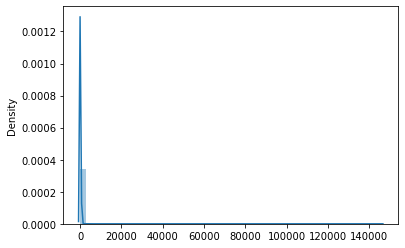

In [14]:
sns.distplot(signal_summary['max_h1'].values)

# Deal with gaps

In [7]:
from matplotlib import colors
from datetime import datetime


def add_gaps(timestamps, fourier_data, Tsft):
    gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)
    gap_data = [fourier_data[:, 0]]
    gap_timestamps = [timestamps[0]]
    for ind, gap in enumerate(gap_length):
        if gap > 0:
            gap_data.append(np.full_like(fourier_data[:, ind], np.nan + 1j * np.nan))
            gap_timestamps.append(timestamps[ind] + Tsft)
        gap_data.append(fourier_data[:, ind + 1])
        gap_timestamps.append(timestamps[ind + 1])
    return np.hstack(gap_timestamps), np.vstack(gap_data).T


def plot_real_imag_spectrograms_with_gaps(timestamps, frequency, fourier_data, Tsft):
    gap_timestamps, gap_data = add_gaps(timestamps, fourier_data, Tsft)
    return plot_real_imag_spectrograms(
        gap_timestamps, frequency, gap_data
    )


def plot_real_imag_spectrograms(timestamps, frequency, fourier_data):
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for ax in axs:
        ax.set(xlabel="SFT index", ylabel="Frequency [Hz]")

    time_in_days = (timestamps - timestamps[0]) / 1800

    axs[0].set_title("SFT Real part")
    c = axs[0].pcolormesh(
        time_in_days,
        frequency,
        fourier_data.real,
        norm=colors.CenteredNorm(),
    )
    fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")

    axs[1].set_title("SFT Imaginary part")
    c = axs[1].pcolormesh(
        time_in_days,
        frequency,
        fourier_data.imag,
        norm=colors.CenteredNorm(),
    )

    fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")

    return fig, axs

In [1]:
# gid = df.iloc[0].id
# fname = Path('input/g2net-detecting-continuous-gravitational-waves/train')/f'{gid}.pickle'
# with open(fname, 'rb') as fp:
#     f = pickle.load(fp)
#     freq = list(f[gid]['frequency_Hz'])
#     sig_h1, time_h1 = f[gid]['H1']['SFTs'], np.array(f[gid]['H1']['timestamps_GPS'])
#     sig_l1, time_l1 = f[gid]['L1']['SFTs'], np.array(f[gid]['L1']['timestamps_GPS'])
#     print(sig_h1.shape, sig_l1.shape)
#     print(time_h1[:50] - time_l1[:50])
#     plot_real_imag_spectrograms_with_gaps(time_h1, freq, sig_h1, 1800)
#     # time_h1_true, sig_h1_true = add_gaps(time_h1, sig_h1, 1800)
#     # time_l1_true, sig_l1_true = add_gaps(time_l1, sig_l1, 1800)
#     match_idx = np.searchsorted(time_l1, time_h1) - 1
#     # print(match_idx)
#     print(time_h1[:50] - time_l1[match_idx][:50])
    

In [13]:
(time_h1[-1] - time_h1[0]) / 1800

5769.898888888889

In [14]:
# print(
#     datetime.utcfromtimestamp(time_h1_true[0]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_h1_true[1]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_h1_true[-1]).strftime('%Y-%m-%d %H:%M:%S')
# ), print(
#     datetime.utcfromtimestamp(time_l1_true[0]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_l1_true[1]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_l1_true[-1]).strftime('%Y-%m-%d %H:%M:%S')
# )

# Wave generation

In [32]:
import math
import pyfstat
from pyfstat.utils import get_sft_as_arrays

def make_signal(idx):
    # signal_depth = np.random.uniform(5, 50)
    signal_depth = 3
    signal_center = np.random.uniform(50, 500)
    noise_kwargs_h1 = {
        "outdir": 'pyfstat',
        "label": f'signal{idx}_h1',
        "duration": 4 * 30 * 86400,
        "tstart": 1238168771,
        "Tsft": 1800,
        "detectors": "H1",
        "sqrtSX": 1e-23,
        "SFTWindowType": "tukey",
        "SFTWindowBeta": 0.01,
        "Band": 0.4,
    }
   
    signal_kwargs_h1 = {
        "F0": signal_center,
        "F1": -1e-10,
        "F2": 0,
        "Alpha": np.random.uniform(0, math.pi * 2),
        "Delta": np.random.uniform(-math.pi/2, math.pi/2),
        "h0": noise_kwargs_h1['sqrtSX'] / signal_depth,
        "cosi": np.random.uniform(-1, 1),
        "psi": np.random.uniform(-math.pi/4, math.pi/4),
        "phi": np.random.uniform(0, math.pi*2),
    }

    writer_h1 = pyfstat.Writer(**noise_kwargs_h1, **signal_kwargs_h1)
    writer_h1.make_data()
   
    freqs_h1, times_h1, sft_data_h1 = get_sft_as_arrays(writer_h1.sftfilepath)
    return sft_data_h1
    

In [35]:
# sft = make_signal(0)

In [36]:
# trns = A.Compose([ToSpectrogram(), AdaptiveResize(8)])
# sft = trns(image=sft['H1'][:, :, None])['image']
# plt.imshow(sft)

<AxesSubplot:xlabel='signal_depth', ylabel='Count'>

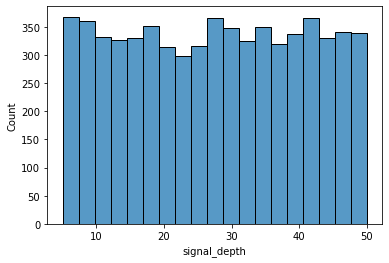

In [5]:
v5_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v6.csv')
sns.histplot(v5_df.query('target == 1')['signal_depth'])

In [6]:
ds = G2Net2022Dataset(
    v5_df, 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v6'),
    match_time=False,
    # spec_diff=True,
    resize_factor=8,
    random_crop=True,
    transforms=A.Compose([ToTensorV2()]),
    normalize='laeyoung',
    fillna=False)

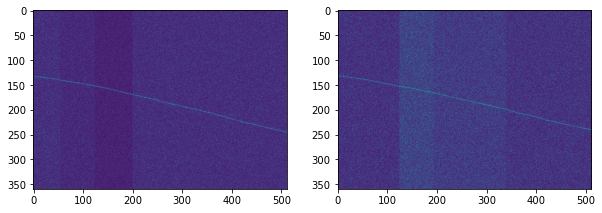

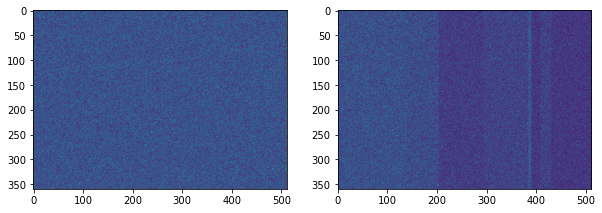

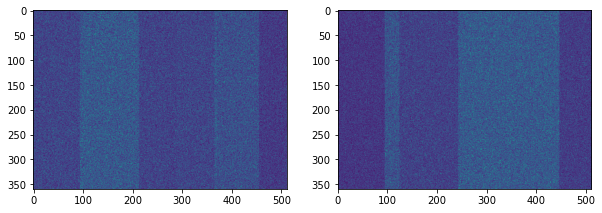

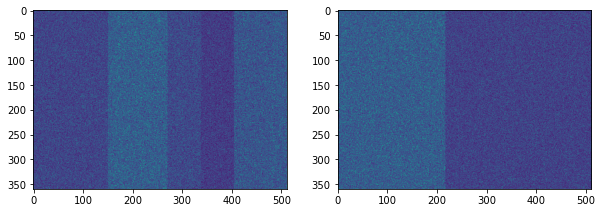

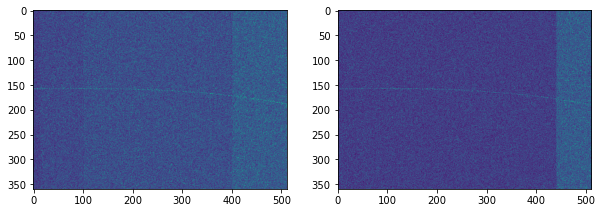

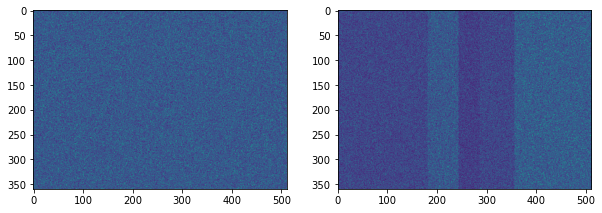

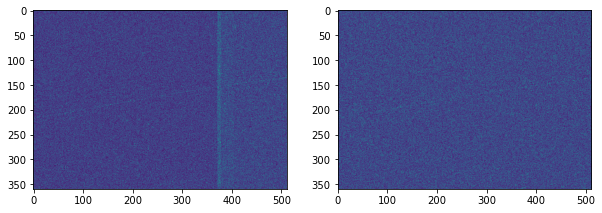

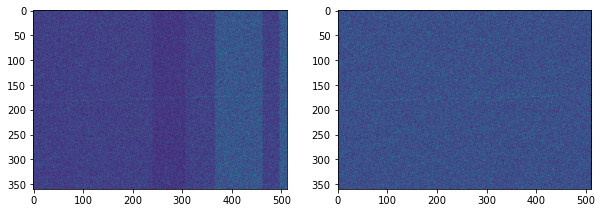

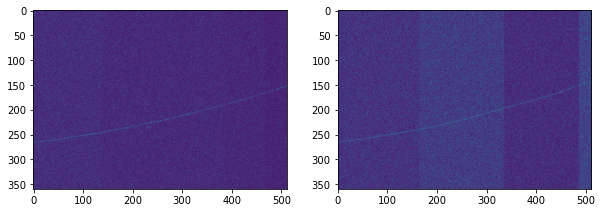

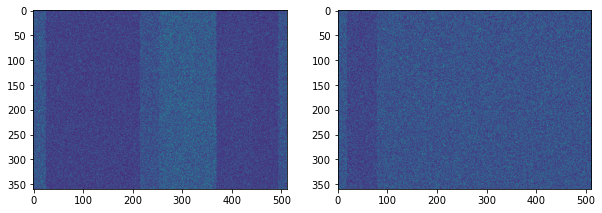

In [7]:
for i in range(10):
    # plt.imshow(ds[i][0].permute(1,2,0))
    plt.figure(figsize=(10, 4))
    specs = ds[i][0]
    plt.subplot(1, 2, 1)
    plt.imshow(specs[0])
    plt.subplot(1, 2, 2)
    plt.imshow(specs[1])
    plt.show()
    # break

In [17]:
ds = G2Net2022Dataset(
    df, 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/train'),
    match_time=False,
    # spec_diff=True,
    resize_factor=8,
    random_crop=True,
    transforms=A.Compose([ToTensorV2()]),
    normalize='local',
    fillna=False)

In [18]:
export_dir = Path('input/plot/train/')
export_dir.mkdir(parents=True, exist_ok=True)
for i in tqdm(range(500)):
    fname = test.iloc[i]['id']
    plt.figure(figsize=(10, 4))
    specs = ds[i][0]
    plt.suptitle(f'{fname}')
    plt.subplot(1, 2, 1)
    plt.imshow(specs[0])
    plt.subplot(1, 2, 2)
    plt.imshow(specs[1])
    plt.savefig(export_dir/f'{fname}.png', facecolor='white')
    plt.close()
    # plt.show()
    # break

  0%|          | 0/500 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Count'>

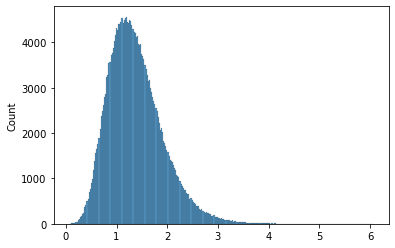

In [19]:
sns.histplot(specs[0].flatten())

<AxesSubplot:ylabel='Count'>

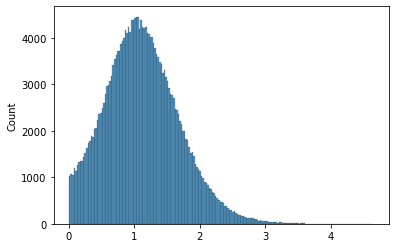

In [23]:
sns.histplot(specs[0].flatten()[specs[0].flatten() > 0])

In [24]:
specs[0].mean()

tensor(1.0890)

# Model

In [18]:
# from replknet import create_RepLKNet31B, create_RepLKNet31L
# from kuma_utils.torch.utils import fit_state_dict
# import torch

In [27]:
# model = create_RepLKNet31B(in_chans=2, num_classes=1)

In [25]:
# checkpoint = torch.load('input/RepLKNet-31B_ImageNet-22K-to-1K_384.pth')
# fit_state_dict(checkpoint, model)
# model.load_state_dict(checkpoint, strict=False)

Size mismatch in stem.0.conv.weight: torch.Size([128, 3, 3, 3]) -> torch.Size([128, 2, 3, 3])
Size mismatch in head.weight: torch.Size([1000, 1024]) -> torch.Size([1, 1024])
Size mismatch in head.bias: torch.Size([1000]) -> torch.Size([1])
